In [216]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from pathlib import Path
import math
from source.dice import Dice
from source.dot import Dot
from source.isCircle import isCircle

# from ipynb.fs.full.functions import isCircle
from source.clustering import distSquare
# good
"2024-06-08_23-37-01_original" # 6,6,2
"2024-06-09_01-02-59_original" # 3,6,5
"2024-06-09_07-44-39_original" # 6,4,5
"2024-05-07_16-07-07_original"
"2024-06-09_07-06-07_original"
'2024-06-09_07-06-07_original'
"2024-06-09_05-36-23_original"
"2024-06-09_05-09-08_original"
"2024-06-08_22-32-54_original"
"2024-06-08_22-48-25_original"
"2024-06-09_07-04-58_original"
# bad
"2024-05-08_10-09-13_original"
"2024-05-09_05-55-43_original"
"2024-05-09_04-54-21_original"

imageName = "2024-06-09_07-20-36_original"
writeToFile = True
outputFolder = f'./data/{imageName}'
diceWidth = 45

# original = cv.imread(f'./data/original/{imageName}.png')
original = cv.imread(f'./newData/{imageName}.png', cv.IMREAD_GRAYSCALE)

assert original is not None, "file could not be read"

if(writeToFile):
    Path(outputFolder).mkdir(parents=True, exist_ok=True)

(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

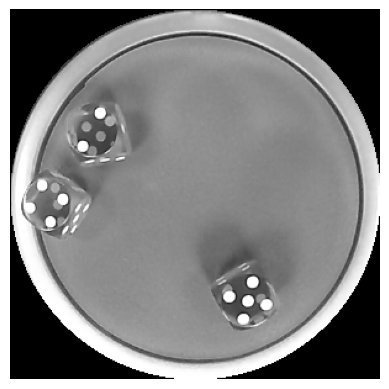

In [217]:
def crop_ring(image, crop_width, crop_height, center):
    center_y, center_x = center

    start_x = max(center_x - crop_width // 2, 0)
    start_y = max(center_y - crop_height // 2, 0)
    end_x = start_x + crop_width
    end_y = start_y + crop_height

    # Crop the image
    cropped_image = image[start_y:end_y, start_x:end_x]

    return cropped_image

ringCenter = (250, 325)
radius = 150
radiusSquared = radius ** 2
center_y, center_x = ringCenter

original = crop_ring(original, radius * 2, radius* 2, ringCenter)
height, width = original.shape

img = original.copy()
height, width = img.shape
center_y, center_x = (height //2, width//2)
Y, X = np.ogrid[:height, :width]
distance_from_center = (X - center_x) ** 2 + (Y - center_y) ** 2
mask = distance_from_center >= radiusSquared
img[mask] = 0


plt.imshow(img, cmap='gray')
plt.axis("off")

(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

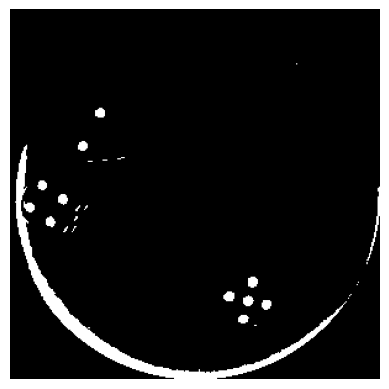

In [218]:
onlyWhite = img.copy()

non_white_mask = onlyWhite <= 250
reverse_mask = ~non_white_mask
# Set all non-white pixels to black (0)
onlyWhite[non_white_mask] = 0
onlyWhite[reverse_mask] = 255

if(writeToFile):
    cv.imwrite(f'{outputFolder}/whitePixels.png', onlyWhite)

plt.imshow(onlyWhite, cmap='gray')
plt.axis('off')
            

(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

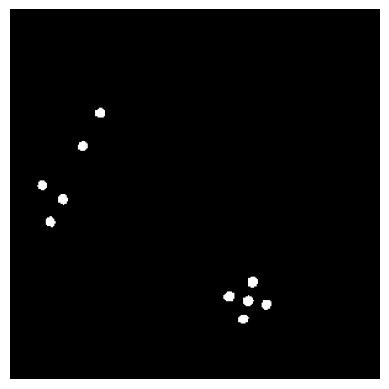

In [219]:
# [0,1,0,0,0,0 ...]
isPixelChecked = np.zeros((height, width), dtype=np.bool)


def findSector(point, onlyWhite):
    arr = [point]
    cluster = []
    while len(arr):
        poped = arr.pop()
        y,x = poped

        if y == height:
            continue
        if x == width:
            continue
        if x < 0:
            continue
        if y < 0:
            continue

        if isPixelChecked[y, x] == 0:
            if onlyWhite[y, x] == 255:
                cluster.append(poped)
                isPixelChecked[y, x] = 1

                arr.append((y, x + 1))
                arr.append((y, x - 1))
                arr.append((y + 1, x))
                arr.append((y - 1, x))
                
    return cluster

dots: list[Dot] = []
for y in range(0, height):
    for x in range(0, width):
        if onlyWhite[y, x] == 255 and isPixelChecked[y, x] == 0:
            pixels = findSector((y, x), onlyWhite)
            dots.append(Dot(pixels))

validDots = []

for index, dot in enumerate(dots):
    dot.calc()

for dot in dots:
    pixelsLen = len(dot.pixels)
    
    if pixelsLen <= 15 or pixelsLen >100:
        for pixel in dot.pixels:
            y,x = pixel
            onlyWhite[y, x] = 0
        continue
    
    if dot.w > 20 or dot.h > 20:
        for pixel in dot.pixels:
            y,x = pixel
            onlyWhite[y, x] = 0
        continue
    
    validDots.append(dot)

for index, dot in enumerate(dots):
    dot.index = index

dots = validDots
validDots = []

for dot in dots:
    if isCircle(dot.dimension(), onlyWhite):
        validDots.append(dot)
    else:
        for pixel in dot.pixels:
            y,x = pixel
            onlyWhite[y, x] = 0
            
            
dots = validDots
validDots = []  
    
if writeToFile:
    cv.imwrite(f"{outputFolder}/dots.png", onlyWhite)

plt.imshow(onlyWhite, cmap="gray")
plt.axis("off")

(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

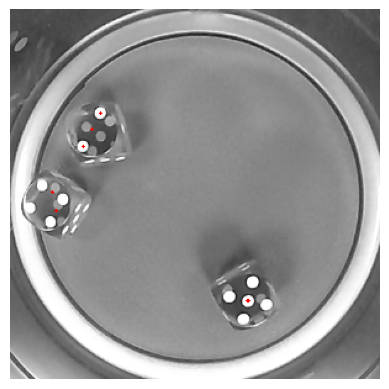

In [220]:
tmpImg2 = cv.cvtColor(original, cv.COLOR_GRAY2RGB)

length = len(dots)

all = []
for i in range(0, length):
    for j in range(0, length):
        dot1 = dots[i]
        dot2 = dots[j]

        cy = (dot1.cy + dot2.cy) / 2
        cx = (dot1.cx + dot2.cx) / 2
        all.append((cy, cx))


def findSector(point, isPixelChecked, onlyWhite):
    arr = [point]
    pixels = []
    while len(arr):
        y, x = arr.pop()

        if y >= height:
            continue
        if x >= width:
            continue
        if x < 0:
            continue
        if y < 0:
            continue

        if isPixelChecked[y, x] == 0:
            if onlyWhite[y, x] == 255:
                isPixelChecked[y, x] = 1
                pixels.append((y, x))
                arr.append((y, x + 1))
                arr.append((y, x - 1))
                arr.append((y + 1, x))
                arr.append((y - 1, x))

    cx = 0
    cy = 0
    for p in pixels:
        cx += p[1]
        cy += p[0]

    if len(pixels) == 0:
        return (0, 0)

    cx /= len(pixels)
    cy /= len(pixels)
    return (cy, cx)


def find_angle_between_points(p1, p2):
    y1, x1 = p1
    y2, x2 = p2
    dx = x2 - x1
    dy = y2 - y1

    angle_radians = math.atan2(dy, dx)

    angle_degrees = math.degrees(angle_radians)

    return angle_degrees


def are_opposite_angles(angle1, angle2, tolerance=20):
    angle1 = angle1 % 360
    angle2 = angle2 % 360

    difference = abs(angle1 - angle2)

    if difference > 180:
        difference = 360 - difference

    return 180 - tolerance <= difference <= 180 + tolerance


def checkDot(point, onlyWhite: cv.typing.MatLike, dots: list[Dot]):
    y, x = point
    roundedY = round(y)
    roundedX = round(x)

    r = diceWidth / 2

    nearDots: list[Dot] = list(
        filter(lambda dot: distSquare(dot.centerPoint, point) < r * r, dots)
    )

    # for d in nearDots:
    #     d.printInfo()

    if len(nearDots) == 0:
        return []

    if len(nearDots) % 2 == 0:
        if onlyWhite[roundedY, roundedX] != 0:
            return []
    else:
        if onlyWhite[roundedY, roundedX] != 255:
            return []

    nearDots.sort(key=lambda d: distSquare(d.centerPoint, point))
    sectored: list[list[Dot]] = []
    
    if len(nearDots) == 1:
        sectored = [[nearDots[0]]]

    if len(nearDots) == 2:
        sectored = [[nearDots[0], nearDots[1]]]
    
    if len(nearDots) == 3:
        sectored = [[nearDots[0]], [nearDots[1], nearDots[2]]]

    if len(nearDots) == 4:
        sectored = [[nearDots[0], nearDots[1], nearDots[2], nearDots[3]]]
    if len(nearDots) == 5:
        sectored = [
            [nearDots[0]],
            [nearDots[1], nearDots[2], nearDots[3], nearDots[4]],
        ]
    if len(nearDots) == 6:
        sectored = [
            [
                nearDots[0],
                nearDots[1],
                nearDots[2],
                nearDots[3],
                nearDots[4],
                nearDots[5],
            ]
        ]

    for s in sectored:
        if len(s) <= 1:
            continue
        angles = [
            find_angle_between_points(point, dot.centerPoint) % 360 for dot in s
        ]
        countChecks = 0
        for index1, angle1 in enumerate(angles):
            check = 0
            for index2, angle2 in enumerate(angles):
                if index2 <= index1:
                    continue
                if are_opposite_angles(angle1, angle2):
                    check = 1

            countChecks += check
        if countChecks != len(s) / 2:
            return []

    return nearDots


valid: list[Dice] = []
allDots: list[Dot] = []
for  point in all:
    # if(index != 9):
    #     continue
    nearDots = checkDot(point, onlyWhite, dots)
    
    if len(nearDots) != 0:
        valid.append(Dice(nearDots, point))
        color = (0, 0, 255)
        y, x = point
        roundedY = round(y)
        roundedX = round(x)
        allDots += nearDots
        tmpImg2 = cv.circle(tmpImg2, (roundedX, roundedY), 1, color, -1)

dots = list(set(allDots))

plt.imshow(cv.cvtColor(tmpImg2, cv.COLOR_BGR2RGB))
plt.axis("off")

In [221]:
def checkDices(dices: list[Dice], dots: list[Dot]):
    value = 0
    for d in dices:
        value += d.value

    if value != len(dots):
        return False
    
    dicesDots = []

    for d in dices:
        dicesDots += d.dots

    return len(list(set(dicesDots))) == len(dots)

filtered: list[list[Dice]]= []

from itertools import combinations

def findValue():
    filtered = [combo for combo in combinations(valid, 2) if checkDices(combo, dots)]
    filtered = [[element.value for element in inner_list] for inner_list in filtered]
    if(len(filtered) != 0):
        filtered = sorted(filtered, key=lambda arr: max(arr), reverse=True)
        return filtered[0]


    filtered = [combo for combo in combinations(valid, 3) if checkDices(combo, dots)]
    
    if(len(filtered) == 0):
        return []
    
    filtered = [[element.value for element in inner_list] for inner_list in filtered]
    filtered = [sorted(inner_list, reverse=True) for inner_list in filtered]
    filtered = sorted(filtered, key=lambda x: (x[0], x[1]), reverse=True)

    return filtered[0]
    

In [222]:
def returnJson(vales: list):
    isValid = len(vales) == 3
    result = list(map(lambda v: f"{v}", vales))

    return {"isValid": isValid, "value": result}

In [223]:
returnJson(findValue())

{'isValid': False, 'value': []}